In [1]:
import tensorflow as tf
import numpy as np
import ray
from ray.rllib import agents
from tqdm.notebook import tqdm
import random
from ray.rllib.policy.policy import Policy
from gym.spaces import Discrete, Box
from ray.rllib.agents.ppo import PPOTrainer
from functools import partial
from ray.tune.logger import pretty_print
from ray.rllib.agents.ppo.ppo_tf_policy import PPOTFPolicy
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

from ray.rllib.models import ModelCatalog
import uuid


import ray
from ray import tune
from ray.tune import track

import math
import gym

import gym_compete_rllib.gym_compete_to_rllib
from gym_compete_rllib.gym_compete_to_rllib import created_envs, create_env
from gym_compete_rllib.load_gym_compete_policy import nets_to_weight_array, nets_to_weights, load_weights_from_vars
from config import get_config_test_external
from train import build_trainer_config, ray_init

import pickle
from copy import deepcopy
from jsonrpcclient.clients.http_client import HTTPClient

from remote_trainer import ExternalTrainer


import os
os.environ['DISPLAY'] = ':0'

In [2]:
ray_init()

{'node_ip_address': '172.25.233.58',
 'raylet_ip_address': '172.25.233.58',
 'redis_address': '172.25.233.58:6379',
 'object_store_address': '/tmp/session_2020-09-08_00-52-49_420469_9552/sockets/plasma_store',
 'raylet_socket_name': '/tmp/session_2020-09-08_00-52-49_420469_9552/sockets/raylet',
 'webui_url': 'localhost:8267',
 'session_dir': '/tmp/session_2020-09-08_00-52-49_420469_9552'}

In [3]:
config_ = get_config_test_external()
config = build_trainer_config(config_)

Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


In [78]:
trainer = ExternalTrainer(config=config)

Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
It looks like variables {<Reference wrapping <tf.Variable 'player_1/Variable:0' shape=() dtype=int64, numpy=0>>,

In [153]:
for _ in range(10):
    res = trainer.train()

retfilter/sum:0 0.01
retfilter/sumsq:0 0.0001
retfilter/count:0 1
obsfilter/sum:0 1
obsfilter/sumsq:0 1
obsfilter/count:0 1
retfilter/sum:0 0.01
retfilter/sumsq:0 0.0001
retfilter/count:0 1
obsfilter/sum:0 1
obsfilter/sumsq:0 1
obsfilter/count:0 1
retfilter/sum:0 0.01
retfilter/sumsq:0 0.0001
retfilter/count:0 1
obsfilter/sum:0 1
obsfilter/sumsq:0 1
obsfilter/count:0 1
retfilter/sum:0 0.01
retfilter/sumsq:0 0.0001
retfilter/count:0 1
obsfilter/sum:0 1
obsfilter/sumsq:0 1
obsfilter/count:0 1
retfilter/sum:0 0.01
retfilter/sumsq:0 0.0001
retfilter/count:0 1
obsfilter/sum:0 1
obsfilter/sumsq:0 1
obsfilter/count:0 1
retfilter/sum:0 0.01
retfilter/sumsq:0 0.0001
retfilter/count:0 1
obsfilter/sum:0 1
obsfilter/sumsq:0 1
obsfilter/count:0 1
retfilter/sum:0 0.01
retfilter/sumsq:0 0.0001
retfilter/count:0 1
obsfilter/sum:0 1
obsfilter/sumsq:0 1
obsfilter/count:0 1
retfilter/sum:0 0.01
retfilter/sumsq:0 0.0001
retfilter/count:0 1
obsfilter/sum:0 1
obsfilter/sumsq:0 1
obsfilter/count:0 1
retfilte

In [154]:
trainer

In [155]:
trainer.logdir

'/home/sergei/ray_results/External_multicomp_2020-09-08_01-08-29swkza5m7/'

In [156]:
trainer.get_policy('player_1').model._nets['policy_mean_logstd'].predict(np.ones((1, 380)))[0][:, 1]

array([-5.9123212e-03, -6.5075787e-05,  6.1686230e-03,  1.5069714e-03,
        1.3524943e-03,  1.1701538e-02, -2.1051797e-03, -3.8758847e-03,
       -3.1649682e-04, -8.2623810e-03, -1.6876991e-05,  4.8423382e-03,
        4.5800167e-03, -1.8819484e-03,  8.0311792e-03,  1.2748739e-03,
       -1.5283438e-03], dtype=float32)

In [157]:
res = trainer.get_policy('player_1').model._nets['policy'].predict(0.01 * np.ones((50000, 380)))

(array([8.0000e+00, 2.2900e+02, 1.7530e+03, 7.3750e+03, 1.5179e+04,
        1.5480e+04, 7.8030e+03, 1.9310e+03, 2.2800e+02, 1.4000e+01]),
 array([-5.2299237 , -4.355803  , -3.4816823 , -2.6075616 , -1.7334408 ,
        -0.85932004,  0.01480069,  0.88892144,  1.7630422 ,  2.637163  ,
         3.5112836 ], dtype=float32),
 <a list of 10 Patch objects>)

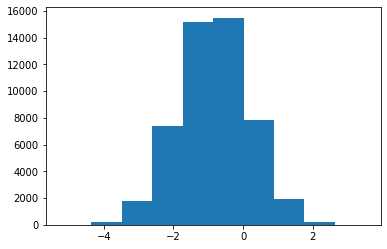

In [91]:
plt.hist(res[:, 3])

In [158]:
from matplotlib import pyplot as plt

In [159]:
np.std(res[:, 3])

0.99912894

In [160]:
pol = trainer.get_policy('player_1')

In [100]:
pol.compute_log_likelihoods(actions=0.01*np.ones((1, 17)), obs_batch=0.01*np.ones((1, 380)), prev_action_batch=0.1*np.ones((1, 17)),
                           prev_reward_batch=np.ones((1, 1)))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-17.902029], dtype=float32)>

In [72]:
v_sb = 1.44048945e-11
v_rllib = -17.135712

In [161]:
actions = np.random.randn(5000, 17)
observations = np.random.randn(5000, 380)
ao = {'a': actions, 'o': observations}

In [228]:
loglik_rllib = pol.compute_log_likelihoods(actions=ao['a'], obs_batch=ao['o'], prev_action_batch=ao['a'],
                           prev_reward_batch=np.ones((5000, 1))).numpy()

In [174]:
pickle.dump(ao, open('ao.pkl', 'wb'))

In [264]:
lik_sb = np.exp(-pickle.load(open('logl_sb.pkl', 'rb')))

In [265]:
p = np.polyfit(loglik_rllib, np.log(lik_sb), deg=1)

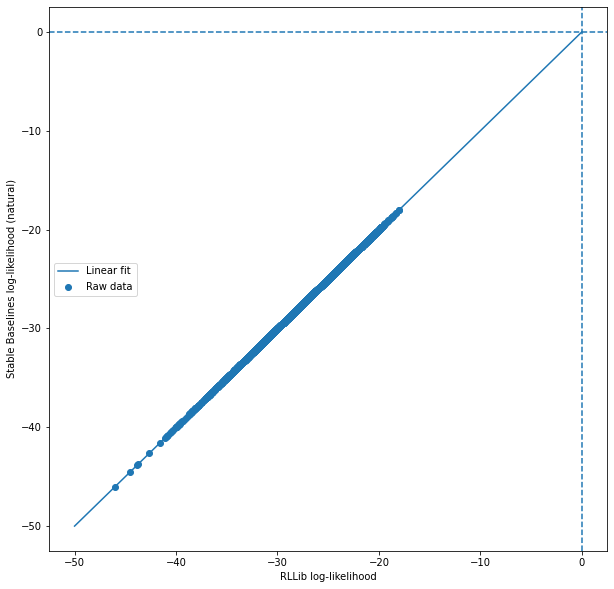

In [266]:
plt.figure(figsize=(10, 10))
plt.scatter(loglik_rllib, np.log(lik_sb), label='Raw data')

plt.xlabel('RLLib log-likelihood')
plt.ylabel('Stable Baselines log-likelihood (natural)')
xs = np.linspace(-50, 0, 20)
plt.plot(xs, p[0] * xs + p[1], label='Linear fit')
plt.axhline(0, ls='--')
plt.axvline(0, ls='--')

plt.legend()
plt.show()

In [267]:
np.exp(p[0])

2.718281806088934

In [268]:
np.e / 2

1.3591409142295225

In [269]:
p

array([ 9.99999992e-01, -3.92553812e-08])

In [181]:
p

array([  0.36818191, -18.37239306])

In [186]:
mean_logstd = pol.model._nets['policy_mean_logstd'].predict(ao['o'])

In [203]:
mean = mean_logstd[:, :, 0]
logstd = mean_logstd[:, :, 1][0, :]

In [209]:
sigma = np.diag(np.exp(logstd) ** 2)

In [194]:
n = mean.shape[1]

In [197]:
xmu = ao['a'] - mean

In [253]:
i = len(xmu) - 1
xmui = xmu[i:i+1, :]

np.log(np.exp(-0.5 * xmui @ np.linalg.inv(sigma)@ xmui.T) / np.sqrt(np.linalg.det(sigma) * (2 * np.pi) ** n))

array([[-19.6024803]])

In [233]:
exp_ll = np.exp(-0.5 * xmu @ np.linalg.inv(sigma) @ xmu.T)
loglik_manual = np.log(np.diag(exp_ll) / np.sqrt(np.linalg.det(sigma) * (2 * np.pi) ** n))

In [254]:
loglik_rllib

array([-25.222132, -24.086132, -30.193739, ..., -26.81917 , -24.710402,
       -19.60248 ], dtype=float32)

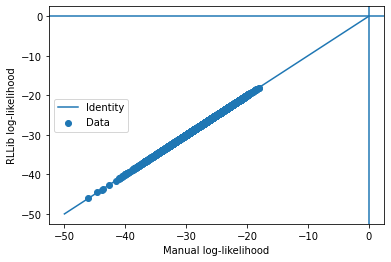

In [240]:
plt.figure()
plt.scatter(loglik_manual, loglik_rllib, label='Data')
plt.axhline(0)
plt.axvline(0)
plt.xlabel('Manual log-likelihood')
plt.ylabel('RLLib log-likelihood')
xs = np.linspace(-50, 0)
plt.plot(xs, xs, label='Identity')
plt.legend()
plt.show()